# 3.2 线性回归的从零开始实现

In [2]:
%matplotlib inline
import torch
from IPython import display
from matplotlib import pyplot as plt
import numpy as np
import random

print(torch.__version__)

1.8.1


## 3.2.1 生成数据集

In [4]:
# 每个样本两个输入
num_inputs = 2
# 1000 个样本
num_examples = 1000
# 真实权重
true_w = [2, -3.4]
# 真实偏差
true_b = 4.2

# 随机生成 1000 * 2 的 tensor 符合常态分布, 也就是 1000 个 特征为 2 的样本
features = torch.randn(num_examples, num_inputs,
                      dtype=torch.float32)
# 生成带有噪音的样本 1000 个 label
labels = true_w[0] * features[:, 0] + true_w[1] * features[:, 1] + true_b
# print(labels)
# 带有噪音

print(type(labels))
labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()),
                       dtype=torch.float32)
print(type(labels))

<class 'torch.Tensor'>
<class 'torch.Tensor'>


In [6]:
print(features[0], labels[0])

tensor([0.4052, 1.7622]) tensor(-0.9906)


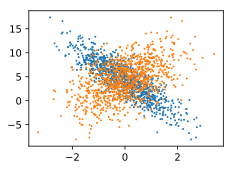

In [9]:
def use_svg_display():
    # 用矢量图显示
    display.set_matplotlib_formats('svg')

def set_figsize(figsize=(3.5, 2.5)):
    use_svg_display()
    # 设置图的尺寸
    plt.rcParams['figure.figsize'] = figsize


set_figsize()
# plt.scatter(x, y, shape)
plt.scatter(features[:, 1], labels, 1);
plt.scatter(features[:, 0].numpy(), labels.numpy(), 1);

## 3.2.2 定义数据迭代器

In [44]:
# 读取数据
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    # 生成 0 ～ len 的 list
    indices = list(range(num_examples))
    # 样本的读取顺序是随机的
    random.shuffle(indices)
    # 从 0 开始, num_examples 结束，步长 batch_size
    for i in range(0, num_examples, batch_size):
        # 每一次迭代将 i ～ i + batch_size 列表索引作为 tensor
        j = torch.tensor(indices[i: min(i + batch_size, num_examples)])
        # 迭代器生成 tensor.index_select(dim=0, 1D index tensor)，dim 维度， 0 代表最外层
        yield  features.index_select(0, j), labels.index_select(0, j)

In [45]:
batch_size = 10


for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[ 1.0758, -0.2007],
        [ 1.4566, -0.6956],
        [ 1.6497,  0.7927],
        [-1.2738, -0.7727],
        [ 0.4205, -0.2816],
        [ 0.7476,  0.4650],
        [-0.1049, -0.0105],
        [ 1.7196,  0.0095],
        [ 0.0802,  0.6967],
        [-0.9924,  1.7452]]) 
 tensor([ 7.0321,  9.4832,  4.8081,  4.2786,  5.9882,  4.1240,  4.0358,  7.5830,
         1.9944, -3.7052])


## 3.2.3 初始化模型参数

In [46]:
# 生成均值 0，方差 0.01 的 [2 * 1] 形状的 tensor
w = torch.tensor(np.random.normal(0, 0.01, (num_inputs, 1)), dtype=torch.float32)
b = torch.zeros(1, dtype=torch.float32)
print(w, b)

tensor([[-0.0041],
        [ 0.0153]]) tensor([0.])


In [47]:
# 声明记录梯度
w.requires_grad_(requires_grad=True)
b.requires_grad_(requires_grad=True)
print(w, b)
print(b.size)

tensor([[-0.0041],
        [ 0.0153]], requires_grad=True) tensor([0.], requires_grad=True)
<built-in method size of Tensor object at 0x7fa795443ca8>


## 3.2.4 定义模型

In [48]:
# 定义线性回归模型
def linreg(X, w, b):
    # 10 * 2 与 2 * 1 tensor 相乘
    return torch.mm(X, w) + b

## 3.2.5 定义损失函数

In [49]:
def squared_loss(y_hat, y):
    # y_hat 是模型运算的预测值, y 是真实值
    return (y_hat - y.view(y_hat.size())) ** 2 / 2

## 3.2.6 定义优化算法

In [50]:
# 代表 optimizer.step() 的作用
def sgd(params, lr, batch_size):  # 本函数已保存在d2lzh_pytorch包中方便以后使用
#     print('params', params), params 是 [w, b] 组成的数组
    for param in params:
        param.data -= lr * param.grad / batch_size # 注意这里更改 param 时用的 param.data

## 3.2.7 训练模型

In [55]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs): # 训练 num_epochs 次
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y).sum()  # l 是有关小批量 X 和 y 的损失
        l.backward()  # 小批量的损失对模型参数求梯度
        sgd([w, b], lr, batch_size)  # 使用小批量随机梯度下降迭代模型参数
        
        # 每次清零梯度不影响下次计算
        w.grad.data.zero_()
        b.grad.data.zero_()
    # train_l = loss(net(features, w, b), labels)
    # print('epoch %d, loss %f' % (epoch + 1, train_l.mean().item()))

In [56]:
print(true_w, '\n', w)
print(true_b, '\n', b)

[2, -3.4] 
 tensor([[ 2.0001],
        [-3.4004]], requires_grad=True)
4.2 
 tensor([4.1996], requires_grad=True)
